In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pathlib import Path
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
import lfp
arm = 'UR5'

TEST_DATASET = "UR5_slow_gripper_test" 
print('Using local setup')
WORKING_PATH = Path().absolute().parent
print(f'Working path: {WORKING_PATH}')
os.chdir(WORKING_PATH)
STORAGE_PATH = WORKING_PATH
print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["UR5", "UR5_high_transition", "UR5_slow_gripper"]]
TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/home/sholto/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


Using local setup
Working path: /home/sholto/Desktop/AI/learning_from_play
Storage path: /home/sholto/Desktop/AI/learning_from_play


In [3]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
# 
RELATIVE = False # use relative joints instead of absolute pos/ori as in the original paper
QUAT =  False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = False
USE_QUAT_OBS = False

LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 5.0
GCBC = False
PROBABILISTIC = False
QUANTISED = False
gripper_proprioception = False
arm = 'UR5'



In [47]:
path = "saved_models/GCSB0_00003"                 #ALLB0.00003_60k"
# hyper_params = np.load(f'{path}/hyper_params.npz', allow_pickle=True)
# scaling = hyper_params['scaling']
# for k,v in hyper_params.items():
#     print(k,v)

In [6]:
import importlib
importlib.reload(lfp)

<module 'lfp' from '/home/sholto/Desktop/AI/learning_from_play/lfp/__init__.py'>

In [7]:
batch_size = 512
dl = lfp.data.PlayDataloader(batch_size=batch_size, include_imgs=False)
valid_data = dl.extract([TEST_DATA_PATH], from_tfrecords=False)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 93.89it/s]


{   'acts': TensorSpec(shape=(512, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(512, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(512, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(512, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(512,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None)}


In [8]:
print(f'Obs: (N,{dl.obs_dim}), Acts: (N,{dl.act_dim}), Goals: (N,{dl.goal_dim})')

Obs: (N,18), Acts: (N,7), Goals: (N,11)


# Load our  models

In [9]:
model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'latent_dim':LATENT_DIM}

actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)


if GCBC:
    encoder = None
    planner = None
else:
    encoder = lfp.model.create_encoder(layer_size=LAYER_SIZE//4, **model_params)
    planner = lfp.model.create_planner(layer_size=LAYER_SIZE//4, **model_params)

In [48]:
lfp.utils.load_weights(path, actor, encoder, planner)

Checkpoint restored


In [11]:
v_it = iter(valid_dataset)
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
T = states.shape[1]
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, T, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, T, 1))
  pred_acts = actor([states, z, goals]) 

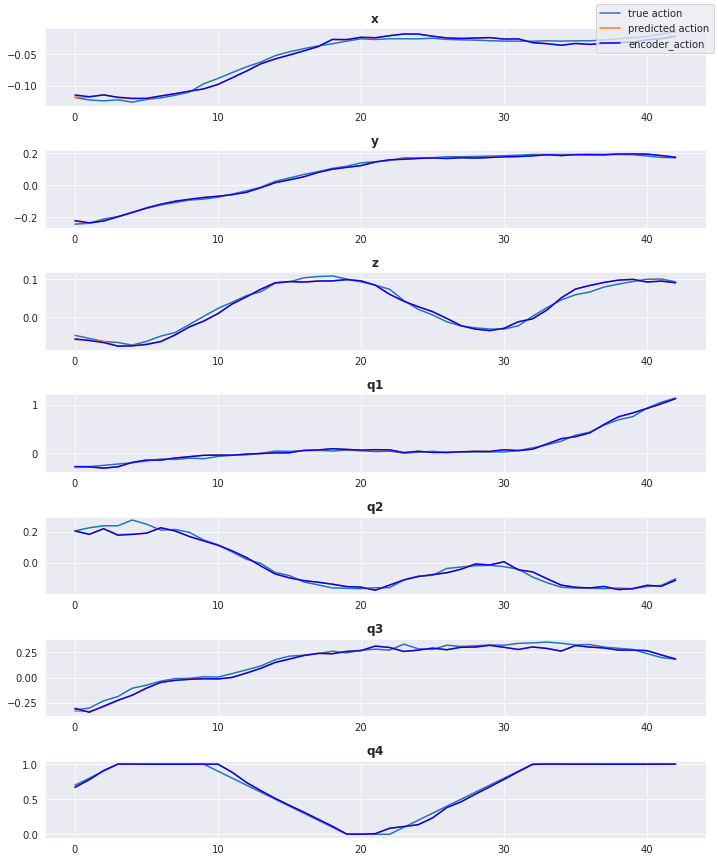

In [12]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 28
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [13]:

batch = iter(valid_dataset).next()

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


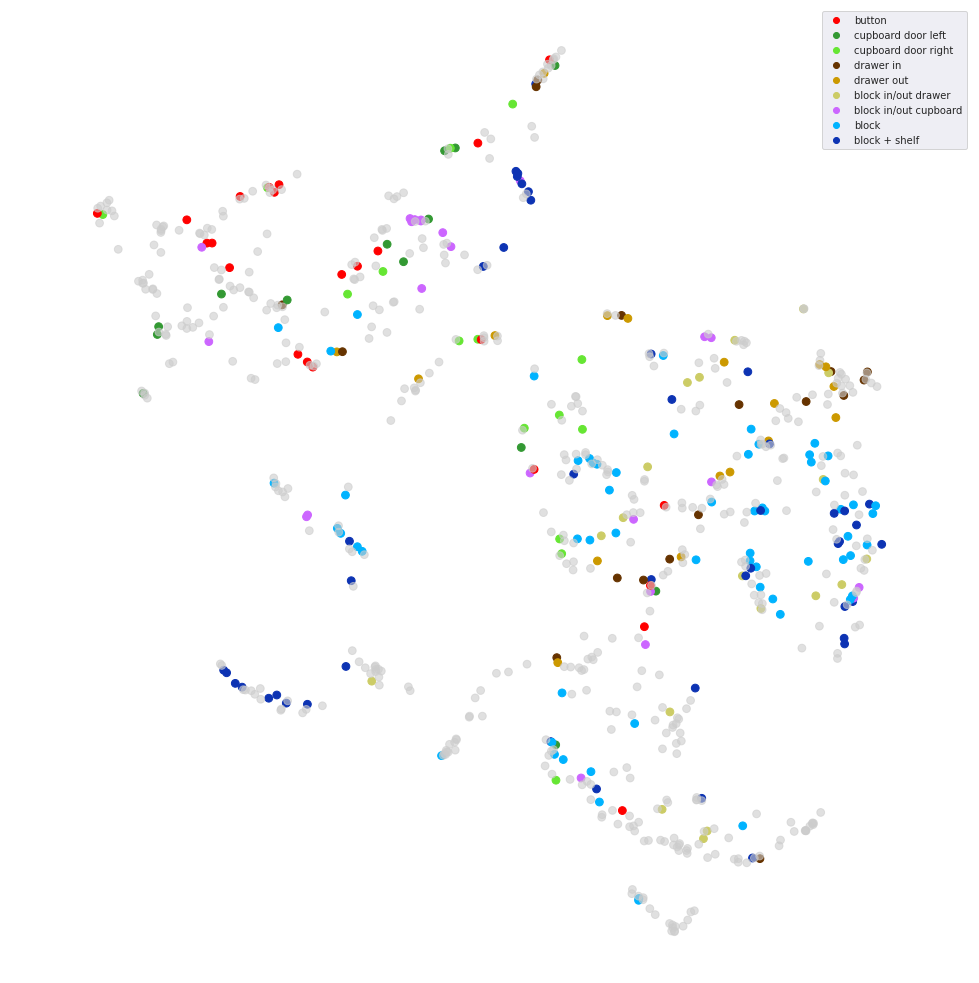

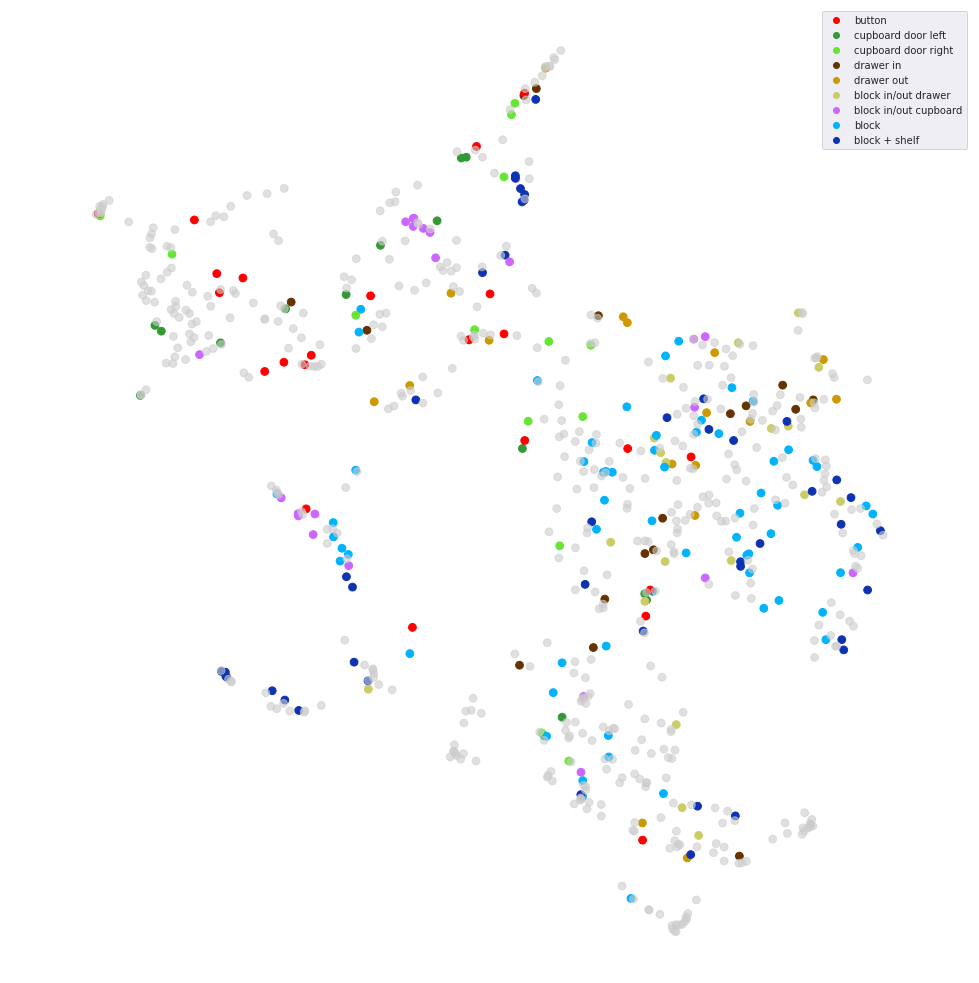

In [51]:
from lfp.plotting import produce_cluster_fig
%matplotlib inline
_ = produce_cluster_fig(batch, encoder, planner, TEST_DATA_PATH, num_take=dl.batch_size)

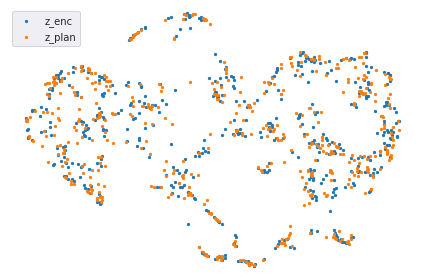

In [14]:
from lfp.plotting import project_enc_and_plan

o = project_enc_and_plan(encoding.sample(), plan.sample(), connecting_lines=False)

In [40]:
env.panda.close()


closing


In [22]:
import gym
import time
import seaborn as sns

import pandaRL

JOINTS, QUAT, RELATIVE = dl.joints, dl.quaternion_act, dl.relative_act

if arm == 'UR5':
    if JOINTS and RELATIVE:
        env = gym.make('UR5PlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('UR5PlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('UR5PlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('UR5PlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('UR5PlayAbsRPY1Obj-v0')
    else:
        env = gym.make('UR5Play1Obj-v0')
else:
    if JOINTS and RELATIVE:
        env = gym.make('pandaPlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('pandaPlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('pandaPlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('pandaPlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('pandaPlayAbsRPY1Obj-v0')
    else:
        env = gym.make('pandaPlay1Obj-v0')
        
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs
current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN',

/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


{'observation': array([ 1.14439107e-01,  2.87613779e-01,  2.69712776e-01,  2.45394488e-03,
         3.02239181e-03, -1.01790565e-05,  9.99992430e-01, -1.39885495e-04,
         6.19614357e-03,  4.03832421e-02, -5.52549791e-05,  6.52996605e-14,
         4.54555318e-14,  7.07106769e-01,  7.07106769e-01,  7.33092193e-17,
         0.00000000e+00,  1.12222219e-02,  0.00000000e+00], dtype=float32),
 'achieved_goal': array([ 6.1961436e-03,  4.0383242e-02, -5.5254979e-05,  6.5299660e-14,
         4.5455532e-14,  7.0710677e-01,  7.0710677e-01,  7.3309219e-17,
         0.0000000e+00,  1.1222222e-02,  0.0000000e+00], dtype=float32),
 'desired_goal': array([-0.11313464,  0.2918081 ,  0.07269463], dtype=float32),
 'controllable_achieved_goal': array([ 1.1443911e-01,  2.8761378e-01,  2.6971278e-01, -1.3988549e-04],
       dtype=float32),
 'full_positional_state': array([ 1.14439107e-01,  2.87613779e-01,  2.69712776e-01,  2.45394488e-03,
         3.02239181e-03, -1.01790565e-05,  9.99992430e-01, -1.39

In [23]:

    
    
model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'latent_dim':LATENT_DIM,
                'training':False, 'return_state':True}

actor = lfp.model.create_actor(layer_size=LAYER_SIZE, gcbc=GCBC, num_distribs=None, **model_params)


In [24]:
def compare_xyz(g, ag, limits = np.array([0.05, 0.05, 0.05])):
    if (abs(g-ag) > limits).any():
        #print('Failed xyz')
        return False
    else:
        return True
    
    
def compare_RPY(g, ag, env, limits = np.array([np.pi/4,np.pi/4,np.pi/4])):
    g = np.array(env.p.getEulerFromQuaternion(g))
    ag = np.array(env.p.getEulerFromQuaternion(ag))
    if (abs(g-ag) > limits).any():
        #print('Failed rpy')
        return False
    else:
        return True
    
def compare_drawer(g, ag, limit=0.025):
    if abs(g-ag) > limit:
        #print('Failed drawer')
        return False
    else:
        return True
    
def compare_door(g, ag, limit=0.03):
    if abs(g-ag) > 0.04:
        #print('Failed door', g, ag)
        return False
    else:
        return True
    
    
def compare_button(g, ag, limit=0.01):
    if abs(g-ag) >limit: 
        #print('Failed button', g , ag)
        return False
    else:
        return True
    
def compare_dial(g,ag, limit=0.3):
    if abs(g-ag) > limit:
        #print('Failed dial')
        return False
    else:
        return True
    
    
def success_func(g, ag):
    g,ag = np.squeeze(g), np.squeeze(ag)
    if compare_xyz(g[0:3], ag[0:3]) and compare_RPY(g[3:7], ag[3:7], env) and compare_drawer(g[7], ag[7]) and compare_door(g[8], ag[8]) and compare_dial(g[10], ag[10]) and compare_button(g[9], ag[9]):
        return True
    else:
        return False

In [25]:
import time

from lfp.plotting import get_labelled_trajs

def clip_action(a):
    #a[0:7] = np.clip(a[0:7], -0.05, 0.05)
    return a

def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(str(TEST_DIR/'states_and_ims'/str(f)/'env_states/*.bullet'))
    print(potential_start_points)
    if config.OS == 'windows':
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states\\", "")) for x in potential_start_points]
    else:
        potential_start_idxs = [int(x.replace('.bullet','').replace(f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
        
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{str(TEST_DATA_PATH)}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts_quat'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
def warm_up(actor, o , goal, z = None):
    for i in range(0,10):
            if GCBC:
                a,_,state = actor((o, goal))
            else:
                a = actor((o, z,goal))
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs_quat'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''
    if USE_QUAT_OBS:
        o = obs_dict['observation']
    else:
        o = obs_dict['obs_rpy']
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(obs_dict['velocity'],tf.float32),0),0)], axis = -1)
    if gripper_proprioception:
         
         o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast([obs_dict['gripper_gripper_proprioception']],tf.float32),0),0)], axis = -1)
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o

def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_TEST_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(TEST_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.panda.calc_state()
    #print(state['achieved_goal'] - goal)
    #print(goal.shape, a_true.shape, o_true.shape, traj_len)
    return goal, a_true, o_true, traj_len, state



def choose_action(actor, o, z, goal, states=None, a_pred=None, a_true=None, replay=False, i=0):
    if GCBC:
        a,_,state = actor((o, goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
        if states is not None:
            states.append(state)
        if a_pred is not None:
            a_pred.append(a)
        pass
    else:
        
        a,_,state = actor((o, z,goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
            
        if a_pred is not None:
            a_pred.append(a)

    if replay or i < 0: # the less than is just so we can set it so the first n are from demonstration- to check if the init is the issue
        a=a_true[i, :] 
    return a

def rollout_subseq(goal,retries=1, replan_horizon=30, a_true=None, o_true=None, traj_len=None, replay=False,end_on_success = False, record_dir=None):
    
    a_pred = []
    states = []
    record_o_buff = []
    plans = [] 
    
    state = env.panda.calc_state()
    o = flatten_obs(state, record_o_buff)
    
    success = 0 
    
    for j in range(0,retries):
        if isinstance(goal, dict):
            # a function which remakes the goal so pertubations of other objects don't matter
            g = goal['func'](*goal['args'])
            env.visualise_sub_goal(np.squeeze(g), 'achieved_goal')
        else:
            g = goal
        
        if GCBC:
            z = None
        else:
            plan = planner((o[0], g[0]))
            z = tf.expand_dims(plan.sample(),0)
            plans.append(z.numpy())
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len

        #warm_up(actor, o, g, z)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, z, g, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            # put the o here
            ag = o['achieved_goal']
            if record_dir is not None:
                record_state(record_dir)
            
            o = flatten_obs(o, record_o_buff)
            if success_func(g, ag):
                success = 1
                
        if end_on_success and success:
            return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans, success
            
        
            
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff)), plans,  success


def test_random_subseq(data, idx, retries = 1, replay=False, replan_horizon=30):
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    a_true, a_pred, states, o_true, record_o_buff, _ = rollout_subseq(goal, retries , replan_horizon, a_true, o_true, traj_len, replay)
    return a_true, a_pred, states, o_true, record_o_buff


##############################################################################
def get_x_of_seq_type(lbl, n = 'all'):
    o, a ,g ,labels, colors, paths = get_labelled_trajs(TEST_DATA_PATH)
    idxs = [ i for i,x in enumerate(labels) if x == lbl]
    print(f"There are {len(idxs)} examples of '{lbl}'")
    if n == 'all':
        return o, a ,g ,labels, colors, paths, idxs
    elif n == 'random':
        idx = np.random.choice(idxs)
        return o, a ,g ,labels, colors, paths, [idx]
    else:
        idx = idxs[n]
        return o, a ,g ,labels, colors, paths, [idx]

def initialise_seq_type(g, paths, idx):

    try:
        env.delete_sub_goal()
    except:
        pass
    print(paths[idx])
    env.p.restoreState(fileName=str(paths[idx]))
    
    env.visualise_sub_goal(g[idx], 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(g[idx], 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    

    return goal

def test_seq_type(data, retries = 1, replay=False, replan_horizon=30):
    o, a ,g ,labels, colors, paths, idxs = data
    successes = []
    for idx in idxs:
        goal = initialise_seq_type(g, paths, idx)
        a_true, o_true, traj_len = a[idx], o[idx], len(a[idx])
        
        a_true, a_pred, states, o_true, record_o_buff, plans, success = rollout_subseq(goal, retries, replan_horizon, a_true, o_true, traj_len,replay)
        successes.append(success)
        
    return successes 




#########################################

def record_state(path):
    t_step = len(list(os.listdir(path)))
    env.p.saveBullet(path +'/'+ str(t_step)) 
    
    

In [26]:
#path = "saved_models/GCSB0_00003"  

In [27]:
lfp.utils.load_weights(path, actor, encoder, planner)

Checkpoint restored


In [28]:
lbl = 'stand up block'
data = get_x_of_seq_type(lbl, n = 'all') # all, random or n

There are 21 examples of 'stand up block'


In [29]:
successes = test_seq_type(data, retries = 1, replay=True, replan_horizon=30)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/420.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5760.bullet


KeyboardInterrupt: 

In [23]:
successes = test_seq_type(data, retries = 10, replay=False, replan_horizon=10)

/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/420.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/5760.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/810.bullet
/home/sholto/Desktop/AI/learning_from_play/data/UR5_slow_gripper_test/states_and_ims/0/env_states/2370.bullet


KeyboardInterrupt: 

In [30]:
block = [0,3]
qqqq = [3,7]
drawer = 7
door = 8
button = 9
dial = 10

door_positions = {'left': -0.15, 'middle': 0.0, 'right': 0.15}

drawer_positions = {'closed': 0.075, 'middle': 0.035, 'open': -0.05}

button_positions = {'open': 0.029, 'closed': -0.029}

dial_positions = {'one':0, 'default': 0.35, 'two': 0.8}

obj_poses = {'default': [0,0.1,0.0], 'shelf':[0,0.43, 0.27],
             'left':[-0.2, 0.2,0.0], 'right':[0.2,0.2,0.0],
             'closed_drawer': [-0.15, 0.1, -0.07], 
             'open_drawer':[-0.15, -0.1, -0.07], 
             'cupboard_left': [-0.2, 0.45, 0.0], 
             'cupboard_right':[0.2, 0.45, 0.0]}

obj_oris = {'upright': [0, -0.7,0,0.7], 'default':[0.0, 0.0, 0.7071, 0.7071], 
            'lengthways':[0,0,0,1]}


In [31]:
def current_ag():
    return env.panda.calc_state()['achieved_goal']

def make_goal(obj, pos=None, ori=None):
    '''
    Ori only applies for the block
    '''
    g = current_ag()
    if isinstance(obj,list):
        if pos is not None:
            g[block[0]:block[1]] = np.array(pos)
        if ori is not None:
            g[qqqq[0]:qqqq[1]] = np.array(obj_oris[ori])
            if ori == 'upright' and pos is not None:
                g[2] += 0.025
            
    else:
        g[obj] = pos
        
    return tf.expand_dims(tf.expand_dims(g,0),0)
    

In [32]:

tasks = {
    'block_left': (block, obj_poses['left'], 'default'),
    'block_right': (block, obj_poses['right'], 'default'),
    'block_shelf': (block, obj_poses['shelf'], 'default'),
    'block_cupboard_right': (block, obj_poses['cupboard_right'], 'default'),
    'block_cupboard_left': (block, obj_poses['cupboard_left'], 'default'),
    'block_drawer':  (block, obj_poses['open_drawer'], 'lengthways'),
    'block_upright': (block,obj_poses['default'], 'upright'),
    'block_lengthways': (block, obj_poses['default'], 'lengthways'),
    'block_lengthways_left': (block, obj_poses['left'], 'lengthways'),
    'block_ori_default': (block, obj_poses['default'], 'default'),
    'button': (button, button_positions['closed']),
    'door_left': (door, door_positions['left']),
    'door_right': (door, door_positions['right']),
    'open_drawer': (drawer, drawer_positions['open']),
    'close_drawer': (drawer, drawer_positions['closed']),
    'dial_on': (dial, dial_positions['one']),
    'dial_off': (dial, dial_positions['two']),
}

In [33]:
kwargs = {'goal':{'func':make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None}

In [52]:
task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_lengthways_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
_ = env.reset()
for i, task in enumerate(task_list):
    kwargs['goal']['args'] = tasks[task]
    _,_,_,_,_,_,succeeded  = rollout_subseq(**kwargs)

KeyboardInterrupt: 

In [34]:
record_path = os.getcwd() + '/recordings/'

def make_recording_dir():
    demo_count = len(list(os.listdir(record_path)))
    example_path = record_path + str(demo_count)
    os.makedirs(example_path)
    return example_path

In [30]:

#env.render('playback') # 10 is good

In [73]:
import shutil
record_path = os.getcwd() + '/recordings/'

while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    path = make_recording_dir()
    successes = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        _,a_pred,_,_,_,succeeded  = rollout_subseq(**kwargs)
        predicted_actions.append(a_pred)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        print(successes)
        if successes <= 10:
            shutil.rmtree(path)
    except:
        pass
    


8
4
11
5
4
11
11
11
6
4
6
2
7
4
9
11
2
6
2
6
11
11
12
12
10
5
11
7
4
7
8
6
4
11
5
12
12
11
7
6
11
9
11
11
6
12
9
4
6
6
4
4
6
6
0
7
0
11
11
11
3
2
8
11
7
11
12
4
11


KeyboardInterrupt: 

In [35]:
import shutil
record_path = os.getcwd() + '/recordings/'

def remove_files(path,x1,x2):
    for step in range(x1,x2):
        os.remove(path+'/'+str(step))
        
        
def reset_from_last(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    env.p.restoreState(fileName = states[-1])

In [42]:
kwargs = {'goal':{'func':make_goal, 'args':None}, 'retries':20, 'replan_horizon':10, 'end_on_success':True, 'record_dir': None}
# 10 is good
while len(list(os.listdir(record_path))) < 50:
    _ = env.reset()
    task_list  = ['close_drawer','dial_off', 'block_right', 'door_left', 'block_shelf', 'open_drawer', 'block_left', 'block_lengthways_left', 'block_cupboard_right', 'door_right', 'button','door_left', 'block_upright']
    #task_list = [ 'block_upright']
    predicted_actions = []
    sampled_plans = []
    indices = [0]
    path = make_recording_dir()
    successes = 0
    total_steps = 0
    for i, task in enumerate(task_list):
        kwargs['goal']['args'] = tasks[task]
        kwargs['record_dir'] = path
        loop = 1
        while loop:
            _,a_pred,_,_,_,plans,succeeded  = rollout_subseq(**kwargs)
            loop = int(input("loop?:"))
            if loop:
                remove_files(path,total_steps,total_steps+len(a_pred))
                reset_from_last(path)
                
            else:
                break
        
        predicted_actions.append(a_pred)
        sampled_plans.append(np.squeeze(np.array(plans)))
        total_steps = len(np.vstack(predicted_actions))
        indices.append(total_steps)
        if succeeded:
            successes += succeeded
        else:
            break

    try:
        np.save(path + '/successes', successes)
        np.save(path + '/predicted_actions', np.vstack(predicted_actions))
        np.save(path + '/indices', np.vstack(indices))
        np.save(path + '/sampled_plans', np.vstack(sampled_plans))
        print(successes)
#         if successes <= 10:
#             shutil.rmtree(path)
    except:
        pass
    


loop?:0
loop?:1
loop?:0
loop?:1
loop?:0
loop?:0
loop?:1
loop?:1
loop?:0
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
loop?:0
loop?:0
loop?:1
loop?:1
loop?:0
loop?:0
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:1
loop?:0
13


KeyboardInterrupt: 

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 101.64it/s]


{   'acts': TensorSpec(shape=(512, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(512, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(512, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(512, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(512,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(512, None, 1), dtype=tf.int32, name=None)}


In [43]:

#fig_plan, scatter = project_labelled_latents(reducer, z_plan.sample(), colors + batch_colors, True)
batch = iter(valid_dataset).next()

In [44]:
import umap
reducer = umap.UMAP(metric='cosine', random_state=42)
from lfp.plotting import bucket_colors, get_labelled_trajs, hold_out
def establish_background(path):
    
    obs, acts, goals, labels, colors, paths = get_labelled_trajs(TEST_DATA_PATH, bucket=True)
    batch_states,batch_acts, batch_goals, batch_colors = batch['obs'][:batch_size, :40, :],batch['acts'][:batch_size, :40, :], batch['goals'][:batch_size, 0, :], [[0.8,0.8,0.8,0.6]]*batch_size
    obs  = np.concatenate([obs, batch_states])
    acts = np.concatenate([acts, batch_acts])
    goals = np.concatenate([goals, batch_goals])
    initial_state = obs[:, 0, :]
    z_plan = planner((initial_state, goals))
    sampled_plans = np.load(path+'/sampled_plans.npy')
    background = z_plan.sample()

    z_space = np.concatenate([background, sampled_plans])

    # Make the colors
    combined_colors = colors+batch_colors
    reducer.fit(z_space)
    z_embed = reducer.transform(z_space)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(z_embed[:len(background), 0], z_embed[:len(background), 1], s=60, label='z', c = combined_colors)
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()


    colors_dict = bucket_colors.copy()
    for i in hold_out:
        del colors_dict[i]
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
    plt.legend(markers, colors_dict.keys(), numpoints=1)
    
    return fig, ax, z_embed[:len(colors)], colors, z_embed[len(background):]

from scipy.spatial import KDTree

def plot_plan(i, z_embed, past_point=None):
    tree = KDTree(z_labelled)
    plan = z_embed[int(i//replan_interval)]
    dd, ii = tree.query(plan, k=1) # get the nns
    spot_color = np.array(label_colors)[ii]# np.mean(np.array(label_colors)[ii], axis=0)
    if pp is not None:
        pp.remove()
    scatter = ax.scatter(z_embed[int(i//replan_interval), 0], z_embed[int(i//replan_interval), 1], s=400, color = spot_color)
    plt.pause(0.01)
    
    return scatter

In [45]:
# This is replaying to visualise the plot 
%matplotlib qt

path = '/home/sholto/Desktop/AI/learning_from_play/recordings//44'
fig, ax, z_labelled, label_colors, z_proposed = establish_background(path)
pp = None

/home/sholto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [46]:

states = natsorted(list(os.listdir(path)))
states = [path+'/'+x for x in states if 'npy' not in x]
acts = np.load(path+'/predicted_actions.npy')
intervals = np.load(path+'/indices.npy')
replan_interval = len(states)/len(z_proposed)


time.sleep(2)
for i,s in enumerate(states):
        if i % replan_interval == 0:
             pp = plot_plan(i, z_proposed, pp)
        env.p.restoreState(fileName = s)
        env.step(acts[i])
        
        
        env.panda.updateToggles()

KeyboardInterrupt: 

In [70]:
def replay_recording(path):
    states = natsorted(list(os.listdir(path)))
    states = [path+'/'+x for x in states if 'npy' not in x]
    acts = np.load(path+'/predicted_actions.npy')
    intervals = np.load(path+'/indices.npy')
    for i,s in enumerate(states):
#         if int(i.split('/')[-1]) > 100:
#             print(i.split('/')[-1])
            env.step(acts[i])
            env.p.restoreState(fileName = s)
            env.panda.updateToggles()
            
            


In [108]:
path = '/home/sholto/Desktop/AI/learning_from_play/recordings//2'


(61, 256)

In [103]:

replay_recording('/home/sholto/Desktop/AI/learning_from_play/recordings//2')
